In [ ]:
import warnings
warnings.filterwarnings("ignore")

c:\Users\anmol\.conda\envs\SSL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anmol\.conda\envs\SSL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


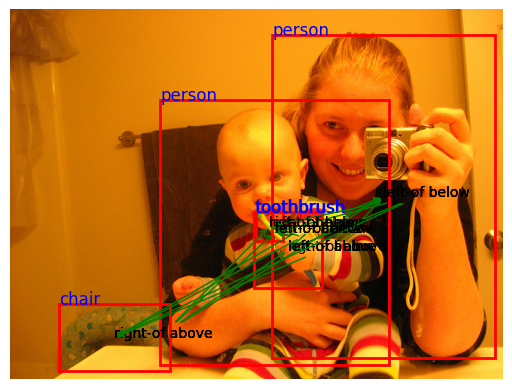

In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
transform = T.Compose([T.ToTensor()])
img = Image.open('000000000692.jpg').convert("RGB")
img_tensor = transform(img)
with torch.no_grad():
    prediction = model([img_tensor])
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
threshold = 0.8
filtered_boxes = boxes[scores >= threshold]
filtered_labels = labels[scores >= threshold]
fig, ax = plt.subplots(1)
ax.imshow(np.array(img))
relationships = []
for i in range(len(filtered_boxes)):
    for j in range(len(filtered_boxes)):
        if i != j:
            box1 = filtered_boxes[i]
            box2 = filtered_boxes[j]
            center1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
            center2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
            relation = ""
            if center1[0] < center2[0]:
                relation += "left-of "
            elif center1[0] > center2[0]:
                relation += "right-of "
            if center1[1] < center2[1]:
                relation += "above"
            elif center1[1] > center2[1]:
                relation += "below"
            if relation:
                relationships.append(((i, j), relation.strip()))
for i, box in enumerate(filtered_boxes):
    x, y, x2, y2 = box
    rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, COCO_INSTANCE_CATEGORY_NAMES[filtered_labels[i]], fontsize=12, color='blue')
for rel in relationships:
    idx1, idx2 = rel[0]
    box1 = filtered_boxes[idx1]
    box2 = filtered_boxes[idx2]
    center1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    center2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
    ax.annotate(rel[1], xy=center1, xytext=center2, arrowprops=dict(arrowstyle="->", color='green'))
plt.axis('off')
plt.show()


0: 480x640 2 persons, 1 chair, 1 cell phone, 1 toothbrush, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
Generated Caption: In a wild scene, a person is overlapping with a person, a person is overlapping with a toothbrush, a person is overlapping with a person, a person is overlapping with a toothbrush, a toothbrush is overlapping with a person, a toothbrush is overlapping with a person


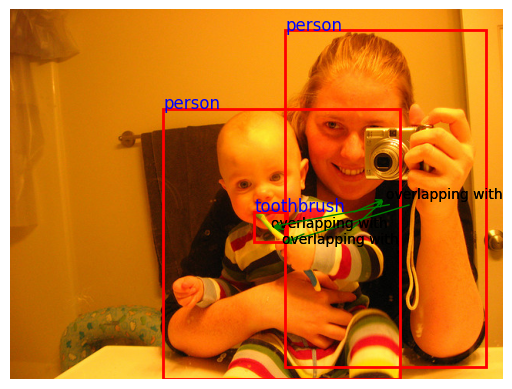

In [4]:
import torch
from ultralytics import YOLO
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import clip

model = YOLO('yolov8n.pt')
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cpu")
transform = T.Compose([T.ToTensor()])
img_path = '000000000692.jpg'
img = Image.open(img_path).convert("RGB")
results = model(img)
boxes = results[0].boxes.xyxy.cpu().numpy()
scores = results[0].boxes.conf.cpu().numpy()
labels = results[0].boxes.cls.cpu().numpy().astype(int)
threshold = 0.5
filtered_boxes = boxes[scores >= threshold]
filtered_labels = labels[scores >= threshold]
rois = []
for box in filtered_boxes:
    x, y, x2, y2 = box
    roi = img.crop((x, y, x2, y2))
    rois.append(roi)
yolo_names = model.names
object_labels = [yolo_names[label] for label in filtered_labels]
with open('categories_places365.txt', 'r') as f:
    scene_labels = [line.strip().split()[0].split('/')[-1] for line in f.readlines()]
img_input = clip_preprocess(img).unsqueeze(0)
text_inputs = clip.tokenize(scene_labels).to("cpu")
with torch.no_grad():
    image_features = clip_model.encode_image(img_input)
    text_features = clip_model.encode_text(text_inputs)
    logits_per_image = (image_features @ text_features.T).softmax(dim=-1)
    best_scene_idx = logits_per_image.argmax().item()
scene_label = scene_labels[best_scene_idx]
relationships = []
for i in range(len(filtered_boxes)):
    for j in range(len(filtered_boxes)):
        if i != j:
            box1 = filtered_boxes[i]
            box2 = filtered_boxes[j]
            center1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
            center2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
            distance = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
            box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
            box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
            intersection = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0])) * max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
            relation = ""
            if intersection > 0:
                relation = "overlapping with"
            elif distance < 100:
                relation = "near"
            elif distance > 300:
                relation = "far from"
            else:
                dx = center1[0] - center2[0]
                dy = center1[1] - center2[1]
                if abs(dx) > abs(dy):
                    relation = "left of" if dx < 0 else "right of"
                else:
                    relation = "above" if dy < 0 else "below"
            relationships.append(((i, j), relation))
fig, ax = plt.subplots(1)
ax.imshow(np.array(img))
for i, box in enumerate(filtered_boxes):
    x, y, x2, y2 = box
    rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, object_labels[i], fontsize=12, color='blue')
for rel in relationships:
    idx1, idx2 = rel[0]
    box1 = filtered_boxes[idx1]
    box2 = filtered_boxes[idx2]
    center1 = [(box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2]
    center2 = [(box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2]
    ax.annotate(rel[1], xy=center1, xytext=center2, arrowprops=dict(arrowstyle="->", color='green'))
def generate_caption(object_labels, relationships, scene_label):
    if len(object_labels) == 0:
        return f"An empty {scene_label} scene."
    objects = object_labels
    if len(objects) == 1:
        return f"A {objects[0]} in a {scene_label} scene."
    caption = f"In a {scene_label} scene, "
    used_pairs = set()
    obj_counts = {}
    for obj in objects:
        obj_counts[obj] = obj_counts.get(obj, 0) + 1
    if len(obj_counts) == 1 and len(objects) > 1:
        return f"Multiple {objects[0]}s in a {scene_label} scene."
    for (idx1, idx2), rel in relationships:
        if (idx1, idx2) not in used_pairs:
            obj1 = objects[idx1]
            obj2 = objects[idx2]
            caption += f"a {obj1} is {rel} a {obj2}, "
            used_pairs.add((idx1, idx2))
    if len(used_pairs) == 0:
        unique_objs = list(obj_counts.keys())
        if len(unique_objs) > 2:
            caption += f"there are {', '.join(unique_objs[:-1])}, and {unique_objs[-1]}."
        else:
            caption += f"there are {' and '.join(unique_objs)}."
    else:
        caption = caption.rstrip(", ")
    return caption.strip()
caption = generate_caption(object_labels, relationships, scene_label)
print("Generated Caption:", caption)
plt.axis('off')
plt.show()

In [7]:
import torch
import cv2

def main():
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    img = cv2.imread('000000000692.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_rgb)
    detections = results.xyxy[0].cpu().numpy()
    for det in detections:
        print(det)
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = results.names[int(cls)]
        cv2.putText(img, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow("Detections", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


Using cache found in C:\Users\anmol/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-2-23 Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\anmol/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[     344.35      30.033      616.21      470.71     0.62353           0]
[     187.32      124.42      506.04      478.26     0.60969           0]
[     316.57      262.88      357.39      300.48      0.6021          79]
[     320.84      262.35      412.88      372.45     0.48122          79]
